In [1]:
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm.notebook import tqdm
from helpers import *
from matplotlib.cm import ScalarMappable
from joblib import Parallel, delayed, parallel_backend
import multiprocessing
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
%matplotlib inline

device = 'cpu'

In [19]:
import matplotlib as mpl

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [2]:
b0, data1 = parse('20060504_072852_NOAA_12.m.pro')
data1 = data1.astype(float)
data1[data1 < 0] = -1000

In [3]:
b0, data2 = parse('20060504_125118_NOAA_17.m.pro')
data2 = data2.astype(float)
data2[data2 < 0] = -1000

In [4]:
point_coors = []
for x in range(346, 1130, 20):
    for y in range(537, 1130, 20):
        point_coors.append([y, x])
wind_size = (31, 31)
vicinity_size = (100, 100)

In [5]:
data1 = torch.tensor(data1).to(device)
data2 = torch.tensor(data2).to(device)

In [6]:
%%time
new_coors = []
scores = []

imgs = None

for point_coor in tqdm(point_coors):
    idx, score = find_best_match_cuda(data1, data2, point_coor, 
                                      wind_size, vicinity_size, ssim_cuda, device,
                                      mode='max')
    new_coors.append(idx)
    scores.append(score)

new_coors = np.array(new_coors)
point_coors = np.array(point_coors)
scores = np.array(scores)

data1 = data1.cpu().numpy()
data2 = data2.cpu().numpy()

  0%|          | 0/1200 [00:00<?, ?it/s]

Wall time: 2min 16s


In [7]:
gv_idx = scores>0.5

In [24]:
annotations = []
colors = ScalarMappable(cmap='viridis').to_rgba(scores)
colors = (colors*255).astype(int)
for i in range(len(new_coors)):
    
    if not gv_idx[i]:
        continue 
        
    annotations.append(dict(
        x= new_coors[i, 1],
        y= new_coors[i, 0],
        xref="x", yref="y",
        text="",
        showarrow=True,
        axref = "x", ayref='y',
        ax= point_coors[i, 1],
        ay= point_coors[i, 0],
        width=2,
        arrowhead = 3,
        arrowwidth=.5,
        arrowcolor=colorFader('#440154', '#1f9e89', scores[i])
    ))

    
#     x += [point_coors[i, 1], new_coors[i, 1], None]
#     y += [point_coors[i, 0], new_coors[i, 0], None]
    

In [26]:
px.colors.Viridis

AttributeError: module 'plotly.express.colors' has no attribute 'Viridis'


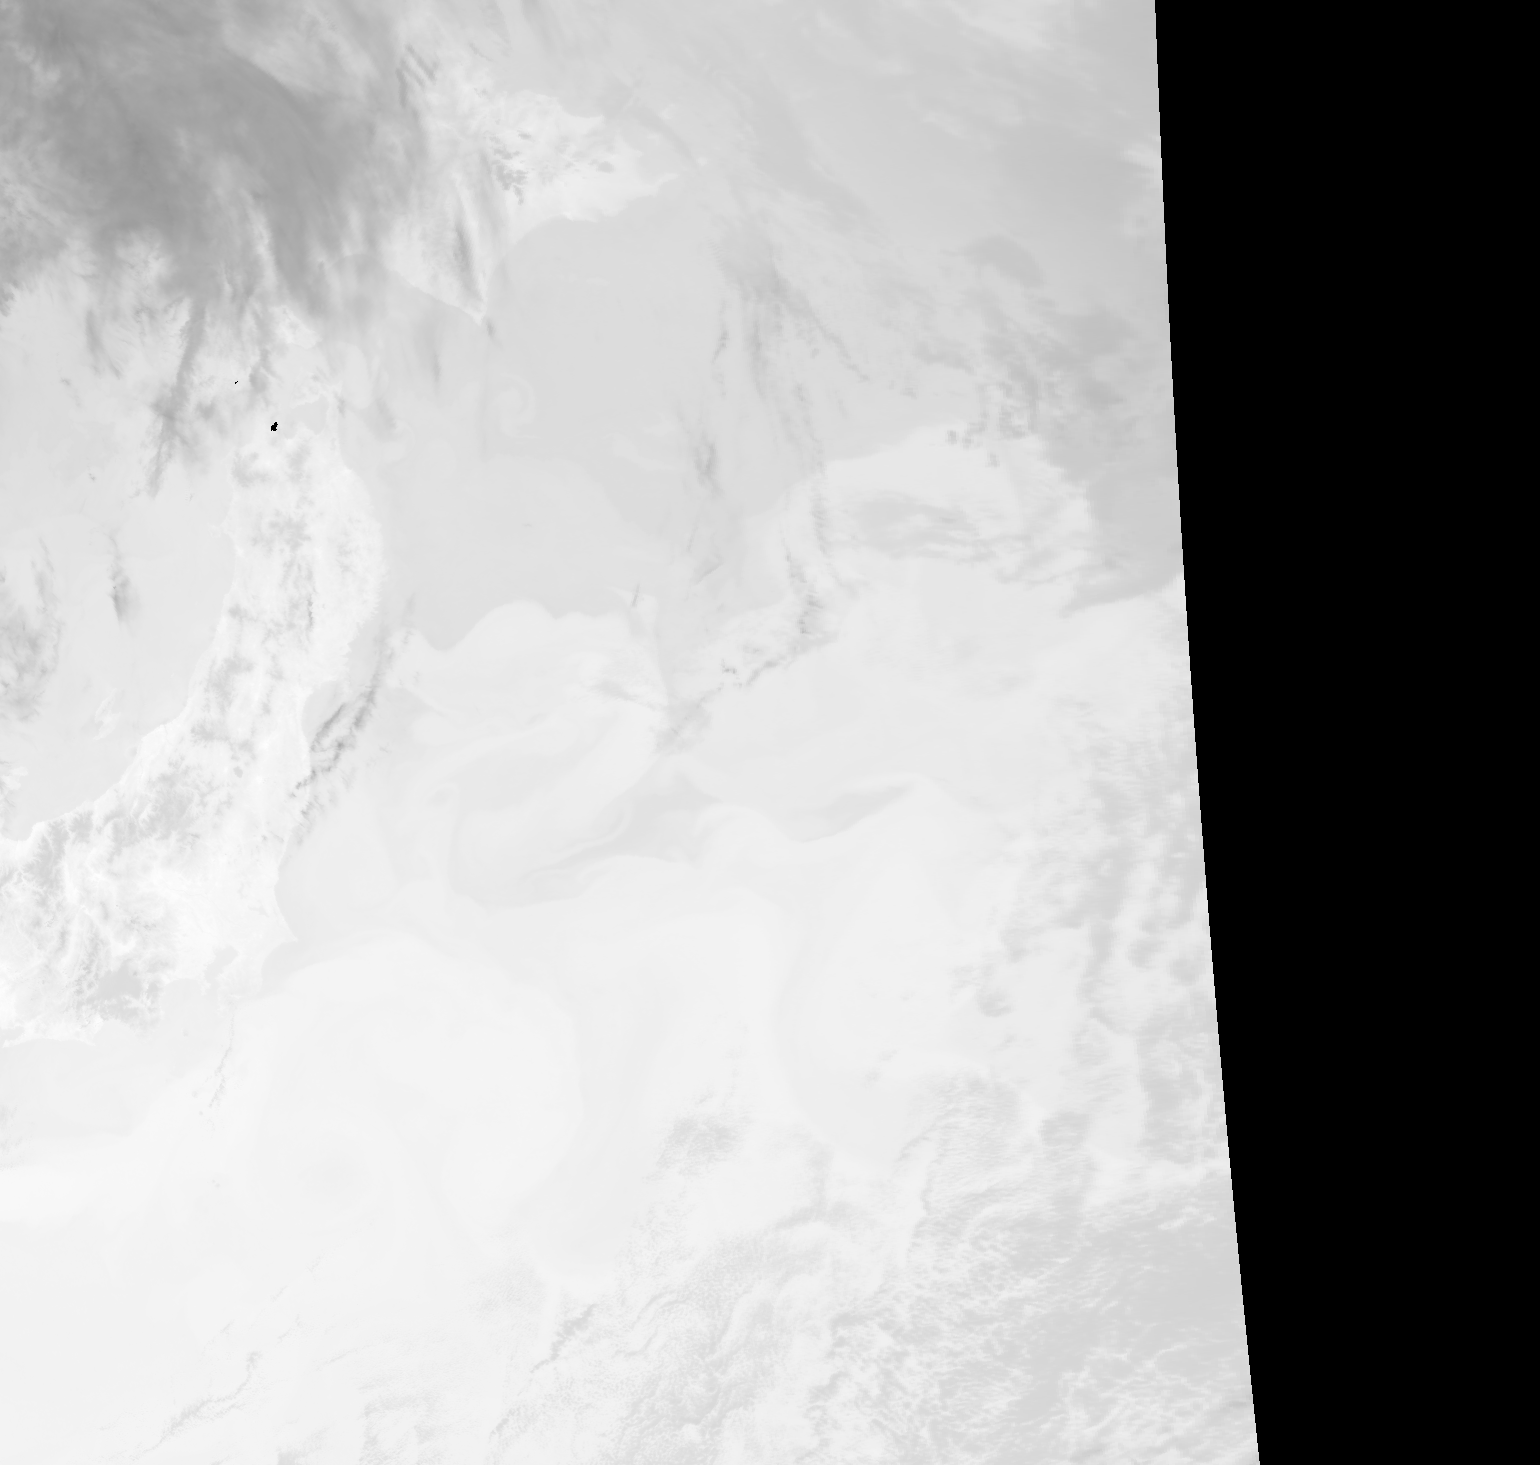

In [25]:
fig = px.imshow(data1, binary_string=True, width=800, height=800)
fig.update_layout(annotations=annotations)
colorbar_trace  = go.Scatter(x=[None],
                             y=[None],
                             mode='markers',
                             marker=dict(
                                 colorscale='viridis', 
                                 showscale=True,
                                 cmin=1,
                                 cmax=0,
                                 colorbar=dict(thickness=30, tickvals=[0, 0.5, 1], ticktext=['Low', 'Medium', 'High'], outlinewidth=0)
                             ),
                             hoverinfo='none'
                            )

fig['layout']['showlegend'] = False
fig.add_trace(colorbar_trace)
fig.show()

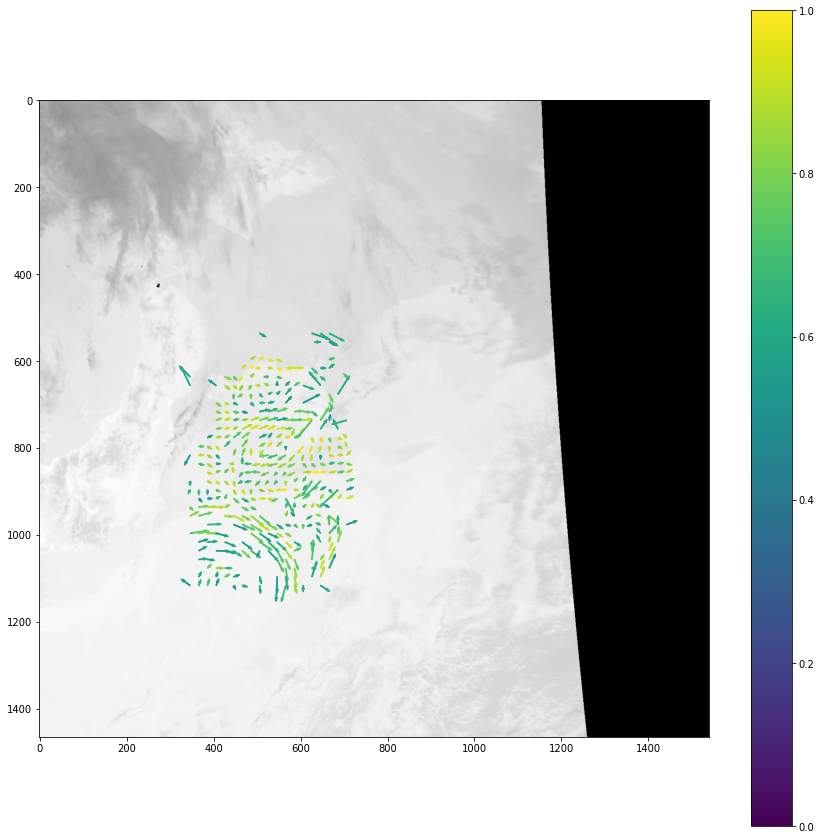

In [8]:
colors = ScalarMappable(cmap='viridis').to_rgba(scores)

fig = plt.figure(figsize=(15, 15))
plt.imshow(data1, cmap='gray')
for x1, y1, x2, y2, color in zip(point_coors[:, 1][gv_idx], point_coors[:, 0][gv_idx], 
                                 new_coors[:, 1][gv_idx], new_coors[:, 0][gv_idx], colors[gv_idx]):
    plt.arrow(x1, y1, x2-x1, y2-y1, width=2, head_width=6, color=color)

fig.colorbar(ScalarMappable(cmap='viridis'))
plt.show()